# Support Vector Machine (SVM)

Support Vector Machines are supervised machine learning models for "maximum-margin" classification tasks.

In [1]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid', palette='deep')
np.random.seed(0)

We have a set of $p$-dimensional features $\mathbf{x}$ and corresponding labels $y$ which can either be $1$ or $-1$.

$$
(\mathbf{x}_i, y_i), ~~~
\forall ~1 \leq i \leq n, ~~
\mathbf{x}_i \in \mathbb{R}^p, ~~
y \in \{-1, 1\}
$$

## Linear SVM

We first consider a SVM with a linear decision boundary, eg for two-dimensional features our model uses a 2d line to classify each data point. The decision boundary, as the form of a hyperplane, have points $x$ satisfying

$$
\mathbf{w}^\top\mathbf{x} - b = 0
$$

with normal vector $\mathbf{w}$.

### Hard-margin

If the training data is linearly separable, ie all data points from each class lies on one side of the hyperplane, we can find two hyperplanes that separate the two classes such that the distance between them are as large as possible. The region in-between is called the "margin". The hyperplanes are described by

$$
\begin{align}
\mathbf{w}^\top\mathbf{x} - b &= 1 ~~~ \text{(anything above this is labelled 1)} \\
\mathbf{w}^\top\mathbf{x} - b &= -1 ~~~ \text{(anything below this is labelled -1)}
\end{align}
$$

where data points that lie on them are known as *support vectors*. To find the distance between the two boundary hyperplanes, consider a point $\mathbf{x}_0$ on the maximum-margin hyperplane, it is $k$-units in the direction of $\mathbf{w}$ away from the boundaries.

$$
\begin{align}
\mathbf{w}^\top(\mathbf{x}_0 + k\frac{\mathbf{w}}{\Vert\mathbf{w}\Vert}) - b &= 1 \\
k\frac{\mathbf{w}\cdot\mathbf{w}}{\Vert\mathbf{w}\Vert} &= 1 \\
k &= \frac{1}{\Vert\mathbf{w}\Vert}
\end{align}
$$

thus the distance between region is $\frac{2}{\Vert\mathbf{w}\Vert}$. To build a linear SVM classifier we would have to maximise this value, or equivalently minimise $\Vert\mathbf{w}\Vert$, subject to the constraints that the training data points lies on the correct side of the hyperplanes.

$$
\begin{gather}
\mathbf{w}^\top\mathbf{x}_i - b \geq 1, ~~\text{if}\ y_i = 1, \text{or} \\
\mathbf{w}^\top\mathbf{x}_i - b \leq 1, ~~\text{if}\ y_i = -1, \\
\\
\text{rewritten as} \\
y_i(\mathbf{w}^\top\mathbf{x}_i - b) \geq 1
\end{gather}
$$

yielding us an optimisation problem

$$
\begin{align}
\underset{\mathbf{w},\ b}{\text{minimise}}~~&\Vert\mathbf{w}\Vert \\
\text{subject to}~~&y_i(\mathbf{w}^\top\mathbf{x}_i - b) \geq 1 ~~~ \forall\ 1 \leq i \leq n
\end{align}
$$

#### Generate random linearly separable dataset

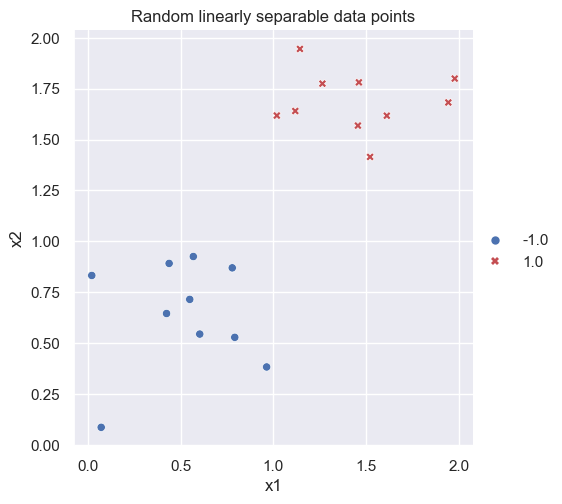

In [2]:
# Each data points have two features x1 and x2 (p=2)
X = np.random.rand(20, 2)
# Translate x1 and x2 to guarantee linear separability. 
X[10:] += 1

y = np.empty(20)
y[:10] = -1
y[10:] = 1

sns.relplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, palette=['b', 'r']).set(
    title='Random linearly separable data points',
    xlabel='x1',
    ylabel='x2')

We will use `scipy`'s constrained optimisation method to solve for our classifier. The objective function $\Vert\mathbf{w}\Vert$ is reformulated to $\frac{1}{2}\Vert\mathbf{w}\Vert^2$ such that its gradient is conveniently $\mathbf{w}$. We also incorporate the bias term into our weights as we have done before in linear regression.

$$
\begin{align}
\mathbf{w}^\prime =&~\{w_1, ..., w_n, -b\} \\
\mathbf{x}^\prime =&~\{x_1, ..., x_n, 1\} \\
\underset{\mathbf{w}^\prime}{\text{minimise}}~~&\frac{1}{2}\Vert\mathbf{w}^\prime\Vert^2 \\
\text{subject to}~~&y_i\mathbf{w}^\top\mathbf{x}^\prime_i - 1 \geq 0 ~~~ \forall\ 1 \leq i \leq n \\
\\
\text{where}~&\nabla \frac{1}{2}\Vert\mathbf{w}^\prime\Vert^2 = \mathbf{w}^\prime \\
\end{align}
$$

In [3]:
X_ = np.hstack([X, np.ones((20, 1))])
hard_margin_res = scipy.optimize.minimize(
    fun=lambda w: 0.5 * np.dot(w, w),
    x0=np.random.randn(3),
    jac=lambda w: w,
    method='SLSQP',
    constraints={'type': 'ineq', 'fun': lambda w: y * np.dot(X_, w) - 1},
    options=dict(ftol=1e-9, maxiter=100))
w = hard_margin_res.x
w

array([ 0.95530355,  2.36766601, -3.8032741 ])

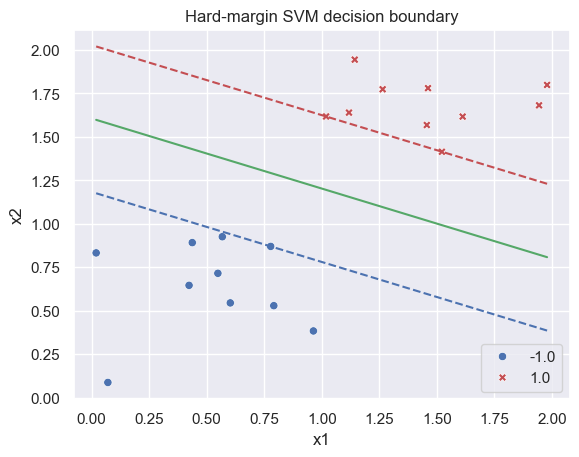

In [4]:
def plot_margin_hyperplane(ax, w, c, **kwargs):
    # Rearrange hyperplane equation to the form y = ax + b
    x0 = np.min(X[:, 0])
    y0 = (c - w[0] * x0 - w[2]) / w[1]
    x1 = np.max(X[:, 0])
    y1 = (c - w[0] * x1 - w[2]) / w[1]
    ax.plot([x0, x1], [y0, y1], **kwargs)
    
ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, palette=['b', 'r'])
ax.set(title='Hard-margin SVM decision boundary', xlabel='x1', ylabel='x2')
plot_margin_hyperplane(ax, w, 0, color='g')
plot_margin_hyperplane(ax, w, 1, linestyle='--', color='r')
plot_margin_hyperplane(ax, w, -1, linestyle='--', color='b')

### Soft-margin

In cases where the data is not linearly-separable, the hard-margin SVM classifier is not solvable. Instead we will use the hinge loss function

$$
\ell(\mathbf{x}_i, y_i; \mathbf{w}) = \text{max}(0, 1 - y_i (\mathbf{w}^\top\mathbf{x}_i - b))
$$

where we penalise data points that are either in the margin or misclassified as the wrong label. For each data point $x_i$, the loss is 0 if it lies on the correct side of the margin, otherwise it will be non-zero and proportional to its distance from the margin.

A soft-margin SVM is solved by minimising

$$
\underset{\mathbf{w}}{\text{minimise}}~ \frac{1}{n}\sum_{i=1}^{n}\ell(\mathbf{x}_i, y_i; \mathbf{w}) + \frac{\lambda}{2}\Vert\mathbf{w}\Vert^2
$$

which has gradient

$$
\nabla_\mathbf{w} f(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n \nabla_\mathbf{w}\ell(\mathbf{x}_i, y_i; \mathbf{w}) + \lambda\mathbf{w}
$$


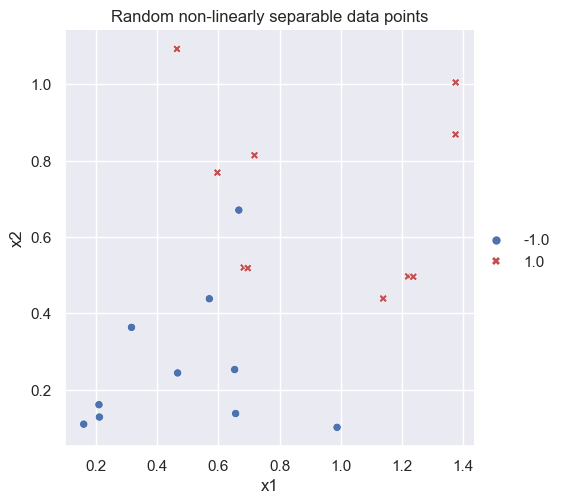

In [5]:
X = np.random.rand(20, 2)
# Only translate 0.4 this time so there are overlaps
X[10:] += 0.4

y = np.empty(20)
y[:10] = -1
y[10:] = 1

sns.relplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, palette=['b', 'r']).set(
    title='Random non-linearly separable data points',
    xlabel='x1',
    ylabel='x2')

The derivative of hinge loss is undefined at $y_i\mathbf{w}^\top\mathbf{x}_i = 1$, a smoothed version shown below is more amenable to optimization. 
$$
\begin{equation}
\ell(\mathbf{x}_i, y; \mathbf{w}) =
    \begin{cases}
        \frac{1}{2} - y_i\mathbf{w}^\top\mathbf{x}_i ~~&\text{if}~y_i\mathbf{w}^\top\mathbf{x}_i \leq 0 \\
        \frac{1}{2}\left(1 - y_i\mathbf{w}^\top\mathbf{x}_i\right)^2 ~~&\text{if}~ 0 \leq y_i\mathbf{w}^\top\mathbf{x}_i \leq 1 \\
        0 &\text{otherwise}
    \end{cases}
\end{equation}
$$

In [6]:
X_ = np.hstack([X, np.ones((X.shape[0], 1))])
def smooth_hinge(w, λ):
    z = y * np.dot(X_, w)
    loss = np.zeros_like(z)
    loss[z <= 0] = 0.5 - z[z <= 0]
    loss[(0 < z) & (z < 1)] = 0.5 * np.pow(1 - z[(0 < z) & (z < 1)], 2)
    return np.mean(loss) + (λ/2) * np.dot(w, w)
def smooth_hinge_grad(w, λ):
    # Use smooth hinge loss
    grad = -y[:, None] * X_
    z = y * np.dot(X_, w)
    mask = (0 < z) & (z < 1)
    grad[mask] = (1 - z)[mask, None] * grad[mask]
    grad[z >= 1] = 0
    return np.mean(grad, axis=0) + λ * w
def soft_margin(λ):
    soft_margin_res = scipy.optimize.minimize(
        fun=smooth_hinge,
        x0=np.random.randn(3),
        args=(λ,),
        jac=smooth_hinge_grad,
        method='CG',
    )
    return soft_margin_res.x
w0 = soft_margin(0)
w1 = soft_margin(0.1)
w0, w1

(array([ 2.93978717,  4.29573147, -4.09543006]),
 array([ 0.56497564,  0.84259705, -0.72913213]))

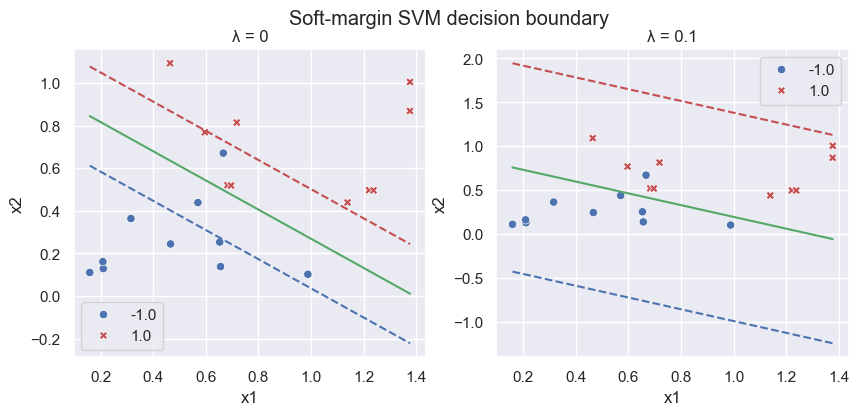

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Soft-margin SVM decision boundary')
for i, (w, λ) in enumerate([(w0, 0), (w1, 0.1)]):
    ax[i].set_title(f'λ = {λ}')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, palette=['b', 'r'], ax=ax[i]).set(xlabel='x1', ylabel='x2')
    plot_margin_hyperplane(ax[i], w, 0, color='g')
    plot_margin_hyperplane(ax[i], w, 1, linestyle='--', color='r')
    plot_margin_hyperplane(ax[i], w, -1, linestyle='--', color='b')